#### Fine-Tuning: DistilBERT

In [2]:
!pip -q install -U datasets transformers accelerate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import Dataset
from datasets.utils.logging import disable_progress_bar

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

C:\Users\ARCHANA\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [4]:
df = pd.read_csv("data/processed/disaster_tweets_preprocessed.csv")
print("Data loaded:", df.shape)
df.head()

Data loaded: (2559, 2)


,processed_text,label
0,us drought monitor 2 29 24 happy leap day for ...,drought
1,synonym is #drought,drought
2,across south america in the last two months #f...,flood
3,wildfires going on in texas #wildfires #texasf...,wildfire
4,start your stand up comedy career for 11 99 pu...,storm


In [10]:
#Label encoding
labels_sorted = sorted(df["label"].unique())
label2id = {label:i for i, label in enumerate(labels_sorted)}
id2label = {i:label for label, i in label2id.items()}

df["label_id"] = df["label"].map(label2id)

print("Classes:", labels_sorted)
df.head()

Classes: ['drought', 'earthquake', 'flood', 'other', 'storm', 'wildfire']


,processed_text,label,label_id
0,us drought monitor 2 29 24 happy leap day for ...,drought,0
1,synonym is #drought,drought,0
2,across south america in the last two months #f...,flood,2
3,wildfires going on in texas #wildfires #texasf...,wildfire,5
4,start your stand up comedy career for 11 99 pu...,storm,4


In [12]:
# Convert to huggingface dataset + split
disable_progress_bar() 

hf_df = df[["processed_text", "label_id"]].rename(columns={"processed_text":"text", "label_id":"label"})
dataset = Dataset.from_pandas(hf_df)
dataset = dataset.train_test_split(test_size=0.2, seed=42)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2047
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 512
    })
})

#### Cleaning

In [20]:
# Make sure text is always a valid string (no NaN, no float, no None)
df["processed_text"] = df["processed_text"].fillna("").astype(str)

# Remove rows where text becomes empty after cleaning
df = df[df["processed_text"].str.strip() != ""]

print("After cleaning:", df.shape)


After cleaning: (2558, 3)


#### Fine-Tuning Pipeline

In [25]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    # Ensure list of strings
    texts = [str(t) for t in batch["text"]]
    return tokenizer(texts, padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)

dataset["train"][0]

{'text': '4 0 magnitude #earthquake 2 km from magas arriba guayanilla #puertorico',
 'label': 1,
 'input_ids': [101,
  1018,
  1014,
  10194,
  1001,
  8372,
  1016,
  2463,
  2013,
  23848,
  3022,
  12098,
  3089,
  3676,
  19739,
  25868,
  9386,
  1001,
  5984,
  7277,
  2080,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

#### Load pretrained model

In [28]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(labels_sorted),
    id2label=id2label,
    label2id=label2id
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### fine-tuning 

In [31]:
# NOTE: older transformers may not support evaluation_strategy, so keep it minimal & compatible.
training_args = TrainingArguments(
    output_dir="./distilbert_results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8
)

#### Train (fine-tune)

In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer
)

trainer.train()

C:\Users\ARCHANA\AppData\Local\Temp\ipykernel_312\25160478.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\ARCHANA\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.109300


TrainOutput(global_step=512, training_loss=0.10677782035782002, metrics={'train_runtime': 463.7328, 'train_samples_per_second': 8.828, 'train_steps_per_second': 1.104, 'total_flos': 96396054057576.0, 'train_loss': 0.10677782035782002, 'epoch': 2.0})

#### Evaluate + Confusion matrix

In [39]:
from sklearn.metrics import classification_report

print(classification_report(
    true_ids,
    pred_ids,
    labels=list(range(len(labels_sorted))),   # force all classes
    target_names=labels_sorted,
    zero_division=0
))


              precision    recall  f1-score   support

     drought       0.99      1.00      1.00       128
  earthquake       1.00      1.00      1.00       100
       flood       1.00      0.99      1.00       101
       other       0.00      0.00      0.00         0
       storm       1.00      1.00      1.00        68
    wildfire       1.00      1.00      1.00       115

    accuracy                           1.00       512
   macro avg       0.83      0.83      0.83       512
weighted avg       1.00      1.00      1.00       512



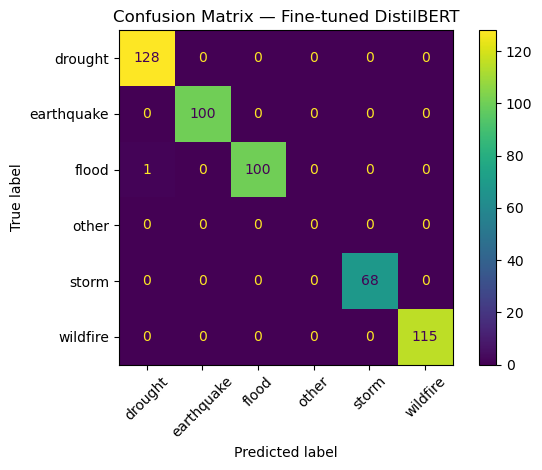

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    true_ids,
    pred_ids,
    labels=list(range(len(labels_sorted)))
)

ConfusionMatrixDisplay(cm, display_labels=labels_sorted).plot(xticks_rotation=45)
plt.title("Confusion Matrix — Fine-tuned DistilBERT")
plt.tight_layout()
plt.show()


#### Save model

In [44]:
model.save_pretrained("saved_distilbert_model")
tokenizer.save_pretrained("saved_distilbert_model")

print("Saved fine-tuned model to: saved_distilbert_model/")


Saved fine-tuned model to: saved_distilbert_model/
